In [ ]:

import torchvision.models as models
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
imsize = 512 
is_cuda = torch.cuda.is_available()

prep = transforms.Compose([transforms.Resize(imsize),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(prep(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


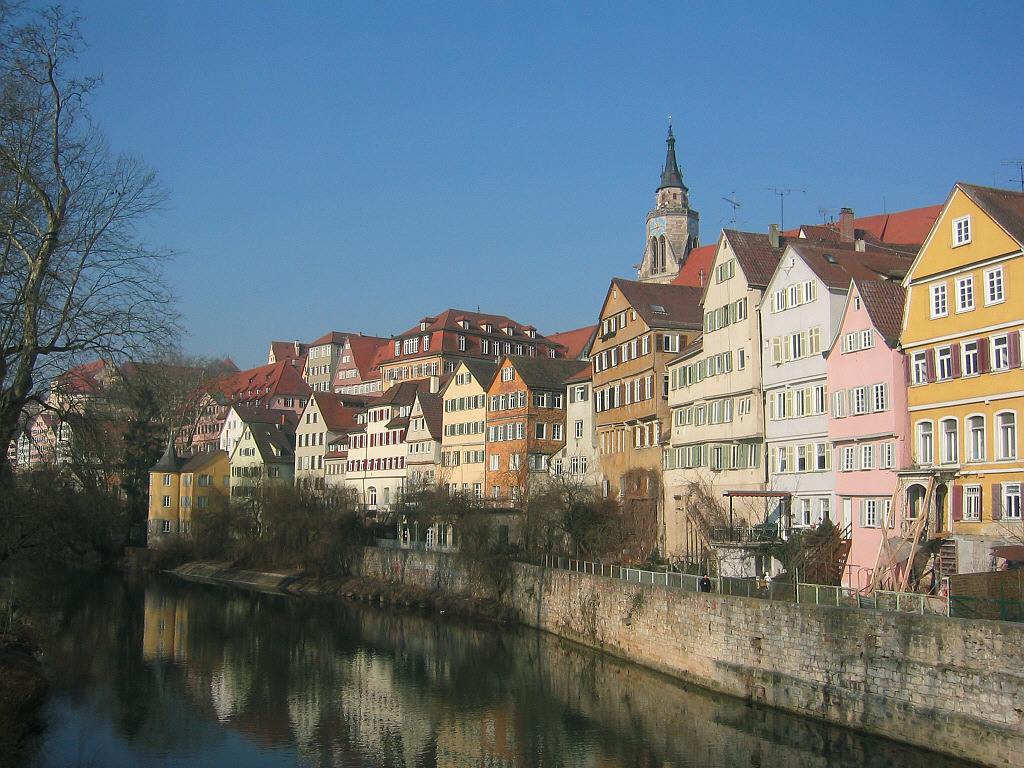

In [ ]:
Image.open('/content/drive/My Drive/Paint.io/Images/Tuebingen_Neckarfront.jpg')

In [ ]:
style_img = image_loader("/content/drive/My Drive/Paint.io/Images/vangogh_starry_night.jpg")
content_img = image_loader("/content/drive/My Drive/Paint.io/Images/Tuebingen_Neckarfront.jpg")
net = models.alexnet(pretrained=True).features
for param in net.parameters():
    param.requires_grad = False
if is_cuda:
    style_img = style_img.cuda()
    content_img = content_img.cuda()
    net = net.cuda()

opt_img = Variable(content_img.data.clone(),requires_grad=True)

In [ ]:
style_layers = [3,6,8]
content_layers = [10]
loss_layers = style_layers + content_layers

In [ ]:
class LayerActivations():
    features=[]
    
    def __init__(self,model,layer_nums):
        
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self,module,input,output):
        self.features.append(output)

    
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
class GramMatrix(nn.Module):
    
    def forward(self,input):
        b,c,h,w = input.size()
        features = input.view(b,c,h*w)
        gram_matrix =  torch.bmm(features,features.transpose(1,2))
        gram_matrix.div_(h*w)
        return gram_matrix
        
class StyleLoss(nn.Module):
    
    def forward(self,inputs,targets):
        out = nn.MSELoss()(GramMatrix()(inputs),targets)
        return (out)

In [ ]:
def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features


content_targets = extract_layers(content_layers,content_img,model=net)
content_targets = [t.detach() for t in content_targets]
style_targets = extract_layers(style_layers,style_img,model=net)
style_targets = [GramMatrix()(t).detach() for t in style_targets]
targets = style_targets + content_targets

In [ ]:
loss_fns = [StyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if is_cuda:
    loss_fns = [fn.cuda() for fn in loss_fns]

In [ ]:
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256]]
content_weights = [1e0]
weights = style_weights + content_weights

In [ ]:
#run style transfer
max_iter = 1000
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        out = extract_layers(loss_layers,opt_img,model=net)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss
    
    optimizer.step(closure)

Iteration: 50, loss: 5897.479980
Iteration: 100, loss: 2322.303711
Iteration: 150, loss: 1569.522095
Iteration: 200, loss: 1252.017944
Iteration: 250, loss: 1072.481689
Iteration: 300, loss: 960.544922
Iteration: 350, loss: 883.787231
Iteration: 400, loss: 830.050293
Iteration: 450, loss: 788.799072
Iteration: 500, loss: 756.535278
Iteration: 550, loss: 728.107422
Iteration: 600, loss: 705.831055
Iteration: 650, loss: 686.692261
Iteration: 700, loss: 670.379272
Iteration: 750, loss: 656.819275
Iteration: 800, loss: 644.226440
Iteration: 850, loss: 633.209717
Iteration: 900, loss: 622.555359
Iteration: 950, loss: 613.246826
Iteration: 1000, loss: 604.985840


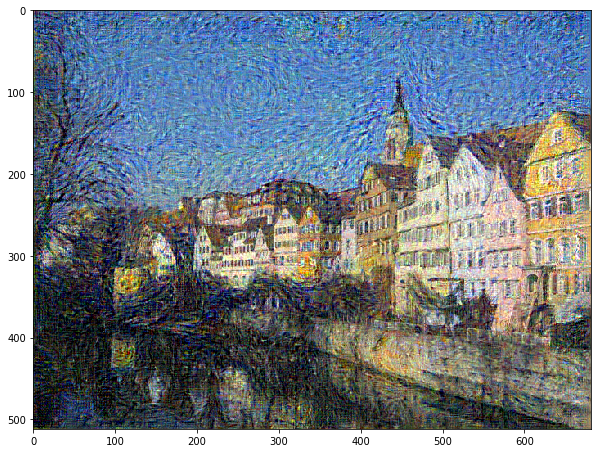

In [ ]:
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

In [ ]:
net


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)